In [1]:
# A modification of  
# C_sf_load_single_LC.py  
# that was routinely used to create 
# master files.


# Only for quasars in  a specified magnitude range, we 
# want to make 'detail' master files,  with  
# all epoch1,  epoch2  data per row , 
# apart from just  delta_mag,  delta_time,  delta_err..




Workflow : 

1) Decide which QSO / stars need to be considered 

2) Create 'detailed master files' with  delta_time,  delta_mag ,  err(delta_mag),  t1, t2,  m1,  m2 , e1, e2 

In [53]:
import os
import numpy as np 
import sys

from CRTS_paper_modules import update_progress  as upd 
import CRTS_paper_modules as mod

## 1) Select QSO  or Stars Sample 

In [54]:

cols1,  qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_catalogs/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


In [64]:
Min_arr = [ 18,   18.5 ]
Max_arr = [ 18.5, 19   ]

qso_names = {}   # need to initialize the dict beforehand !!! 
star_names = {}   # need to initialize the dict beforehand !!! 

mag = 'r'   # which magnitudes to use for cutting and reporting 
        
for i in range(len(Min_arr)):
    
    Min = Min_arr[i]
    Max = Max_arr[i]

    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, mag, Max))

    # having gi from -1 to 3  includes both blue and red stars 
    good_ids_stars = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                          gi_Max=3, cut_mag=mag + '_mMed')
   
    good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                           cut_mag=mag)

    qso_names[Min] = good_ids_QSO
    star_names[Min]   = good_ids_stars
    
    


Using now only lightcurves with SDSS  18.000000< r < 18.500000

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3487

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 333

Using now only lightcurves with SDSS  18.500000< r < 19.000000

Choosing stars with  SDSS   -1.00<g-i<3.00
 These cuts reduced the number of stars  in the sample from 48250 to 3825

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 747


## 2)  Create detailed master files 

In [ ]:

choice = 'stars'  # 'qso'
survey  = 'CRTS'

inDir =  '../proc_LC_'+survey+'/'+choice+'/'
outDir = '../data_products/sf_file_per_LC/' +choice+'_detailed/'

for m in range(len(Min_arr)) : 
    Min = Min_arr[m]
    Max = Max_arr[m]

    
    if choice == 'qso' : 
        names = qso_names[Min]
        
    if choice == 'stars':
        names = star_names[Min]
        
    total = float(len(names))
    count = 0
    
    print('Preparing detailed master files for %s, in range %.2f-%.2f'%(choice, Min, Max))
    
    for i in range(len(names)): 

        percent = 100*(count / total)
        if (count % 10) == 0 : # every tenth loop.. 
            upd(int(percent)) # print progress bar  
        count += 1
        
        if choice == 'qso':
            name  = 'out_'+names[i] +'.txt'
            
        if choice == 'stars' : 
            name = 'out_' + names[i]+'.dat.txt'
            
        # load the mjd, flux, and flux_error  from the read file 
        mjd,flx,err = np.loadtxt(inDir+name,usecols=(0,1,2),unpack=True)

        # check for any nan's...
        add = np.where(np.isnan(flx) == True)[0]

        # Delete all rows with nan's - there should be none in files I provide.. 
        mjd = np.delete(mjd,add); flx = np.delete(flx,add); err = np.delete(err,add)

        # Sort according to mjd's 
        ind = np.argsort(mjd)
        mjd = mjd[ind]; flx = flx[ind]; err = err[ind]

        # Calculate tau, mag difference and err difference for each pair (k,j), 
        # where tau=t_j-t_k (j>k) 

        # declare a priori the storage to make more efficient - 
        # appending is not very quick ... 
        N = np.sum(np.arange(2, len(mjd)+1)-1)

        delflx = np.zeros(N);  delflxerr = np.zeros(N); tau = np.zeros(N)
        t1 = np.zeros(N) ;   t2 =np.zeros(N);     m1 =np.zeros(N);  m2 =np.zeros(N)
        e1=np.zeros(N); e2   =np.zeros(N)

        pos = 0 
        for j in range(len(mjd)-1):
            for k in range(j+1):     
                tau[pos] = mjd[j+1]-mjd[k]   # 
                delflx[pos] = flx[j+1] - flx[k]
                delflxerr[pos] = np.sqrt(err[k]**2+err[j+1]**2)
                t1[pos] = mjd[k] ; t2[pos] = mjd[j+1]
                m1[pos] = flx[k] ; m2[pos] = flx[j+1]
                e1[pos] = err[k] ; e2[pos] = err[j+1]

                pos  += 1 

        # sort according to tau
        #int0 = np.argsort(tau)
        #tau = tau[int0]; delflx = delflx[int0]
        #delflxerr = delflxerr[int0]


        ##### FILE SAVING #######
        DATA = np.column_stack((delflx,tau, delflxerr, t1, t2, m1, m2, e1, e2))    
        outfile = outDir + 'SF_' + names[i] + '.txt'
        np.savetxt(outfile, DATA, delimiter =' ', fmt="%s") 

    print('\nAll in all, we saved %d SF files ' % (count))  

Preparing detailed master files for stars, in range 18.00-18.50
[####      ] 48.00%

(array([ 8.,  6.,  7.,  2.,  4.,  2.,  6.,  5.,  3.,  2.]),
 array([   5.0489 ,   23.41045,   41.772  ,   60.13355,   78.4951 ,
          96.85665,  115.2182 ,  133.57975,  151.9413 ,  170.30285,
         188.6644 ]),
 <a list of 10 Patch objects>)

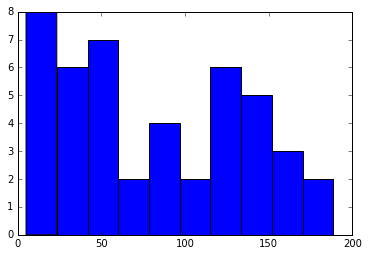

In [39]:
3) Test reading-in ... 


